In [42]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [43]:
ticker1 = 'AAPL'
year1 = 2024

In [44]:
def loadreturns(ticker:str, year):
    prices = yf.download(ticker,start=f"{year}-01-01",end=f"{year + 1}-01-01")['Close']
    return prices
    
def logreturns(prices):
    LogR = np.log(prices / prices.shift(1)).dropna()
    return LogR             

In [45]:
prices = loadreturns(ticker1,year1)
df = logreturns(prices)
mean = df.mean()
sigma = df.std()
skew = df.skew()
kurtosis = df.kurtosis() -3 
print(f'mean = {mean}')
print(f'sigma = {sigma}')
print(f'skew = {skew}')
print(f'kurtosis = {kurtosis}') 

[*********************100%***********************]  1 of 1 completed

mean = Ticker
AAPL    0.001212
dtype: float64
sigma = Ticker
AAPL    0.014063
dtype: float64
skew = Ticker
AAPL    0.392669
dtype: float64
kurtosis = Ticker
AAPL    0.440328
dtype: float64


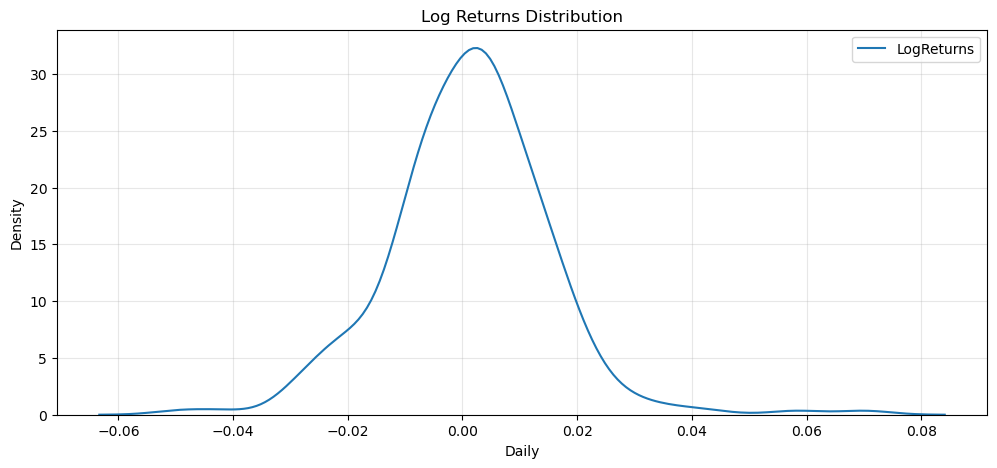

In [46]:
plt.figure(figsize=(12,5))

sns.kdeplot(df, color="blue", label="LogReturns")

x = np.linspace(min(df.min()), max(df.max()), 200)

plt.title("Log Returns Distribution")
plt.xlabel("Daily")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [47]:
"""
    Simulates Monte Carlo price paths under a Geometric Brownian Motion (GBM)

    Parameters
    prices : pd.Series
        Historical price series (e.g. Close prices) for year_sim
    ticker : str
        Asset ticker
    year_prev : int
        Year used to estimate mu and sigma
    year_sim : int
        Year to simulate
    n_paths : int
        Number of Monte Carlo trajectories
    dt : float
        Time step (1 = daily)
    seed : int
        Random seed for reproducibility

    Returns
    S : np.ndarray
        Simulated price paths of shape (n_steps + 1, n_paths)
"""
def simulate_gbm_mc(prices,ticker,year_prev,year_sim,n_paths=5,dt=1,seed=19):
   
    #Initial price 
    S0 = float(prices.iloc[0])

    #Load prices 
    prices_prev = loadreturns(ticker, year_prev)
    prices_sim = loadreturns(ticker, year_sim)

    #Compute log-returns 
    returns_prev = logreturns(prices_prev)
    returns_sim = logreturns(prices_sim)

    #Parameter estimation (daily)
    mu = float(returns_prev.mean())
    sigma = float(returns_prev.std())

    #Number of steps 
    n_steps = int(len(returns_sim))

    #GBM coefficients 
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)

    #Storage matrix 
    S = np.zeros((n_steps + 1, n_paths))
    S[0, :] = S0

    #Random shocks 
    np.random.seed(seed)
    Z = np.random.normal(0, 1, size=(n_steps, n_paths))

    #Simulation loop 
    for t in range(n_steps):
        S[t + 1, :] = S[t, :] * np.exp(drift + diffusion * Z[t, :])

    return S


In [48]:
def plot_mc_vs_history(prices, S, title):
    plt.figure(figsize=(14, 8))

    # Historical price
    plt.plot(
        prices.index,
        prices.values,
        label="Historical price",
        linewidth=3,
        color="black"
    )

    # Monte Carlo paths
    for i in range(S.shape[1]):
        plt.plot(
            prices.index[1:],
            S[1:, i],
            linestyle="--",
            linewidth=2,
            alpha=0.8,
            label=f"MC path {i+1}"
        )

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Price", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


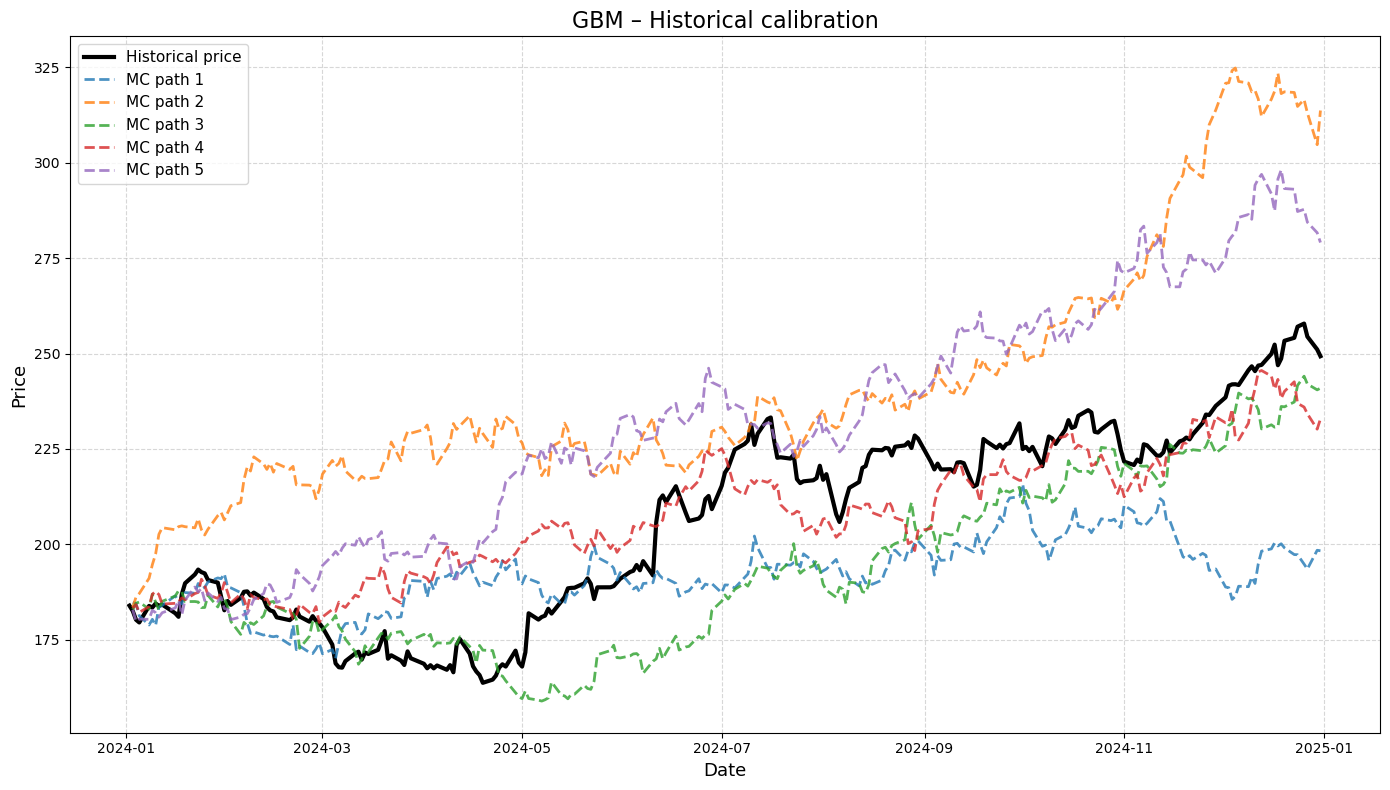

In [49]:
S_hist = simulate_gbm_mc(prices, ticker1, year1-1, year1)
plot_mc_vs_history(prices, S_hist, "GBM – Historical calibration")


In [50]:
#Monte Carlo GBM with RANDOM mu and sigma

def simulate_gbm_mc_random(prices, year_sim, n_paths=5, dt=1, seed=42, mu_range=(-0.002, 0.002), sigma_range=(0.005, 0.05)):

    np.random.seed(seed)

    #Random parameters
    mu = np.random.uniform(*mu_range)
    sigma = np.random.uniform(*sigma_range)

    #Initial price
    S0 = float(prices.iloc[0])

    #Number of steps
    n_steps = len(prices) - 1

    #GBM coefficients
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)

    #Storage
    S = np.zeros((n_steps + 1, n_paths))
    S[0, :] = S0

    #Shocks
    Z = np.random.normal(0, 1, size=(n_steps, n_paths))

    for t in range(n_steps):
        S[t + 1, :] = S[t, :] * np.exp(drift + diffusion * Z[t, :])

    return S, mu, sigma


Random mu: -0.0005018395246105501 Random sigma: 0.04778214378844623


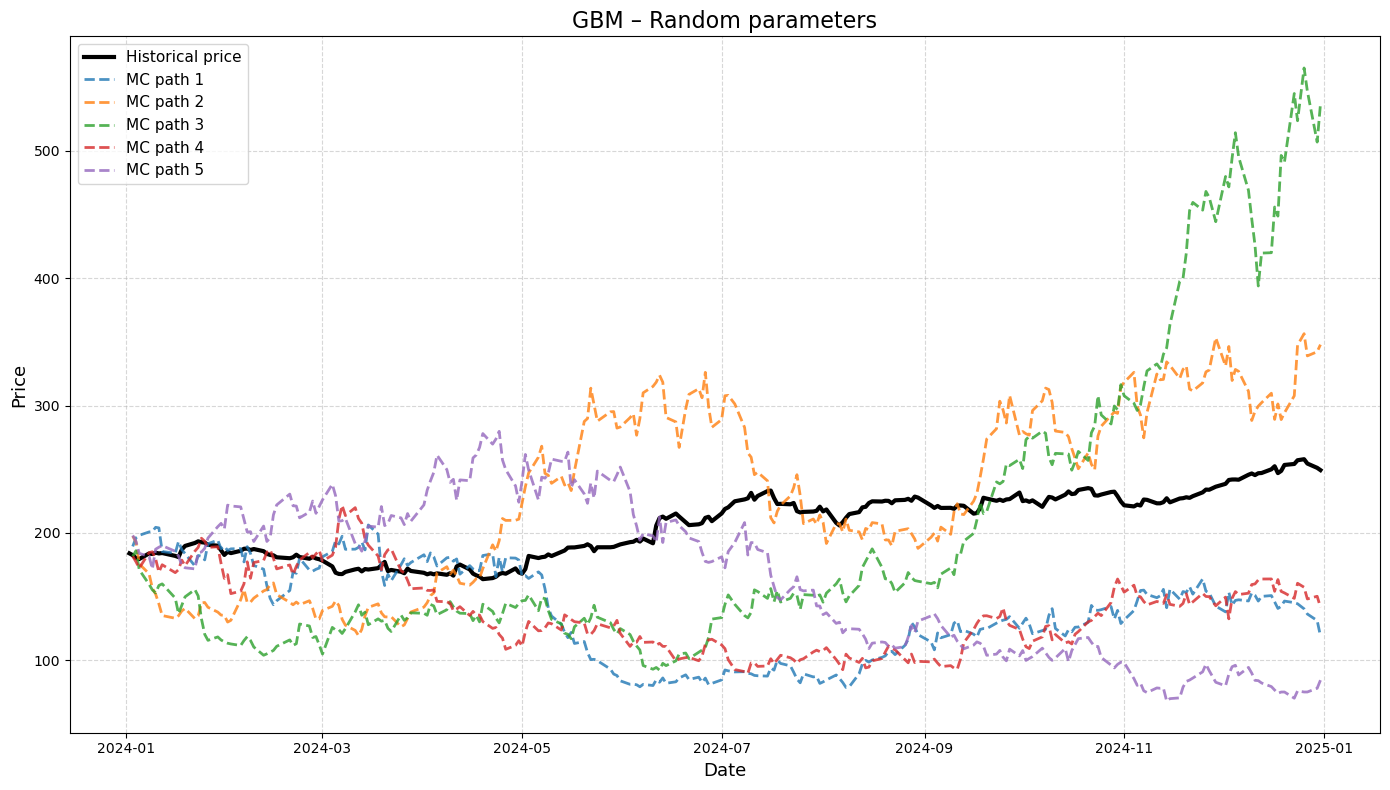

In [51]:
S_rand, mu_r, sigma_r = simulate_gbm_mc_random(prices, year1)
print("Random mu:", mu_r, "Random sigma:", sigma_r)

plot_mc_vs_history(prices, S_rand,"GBM – Random parameters")


In [52]:
#Monte Carlo GBM with rolling (short-window) calibration of mu and sigma

def simulate_gbm_mc_short_window( prices,ticker,year_prev,year_sim,n_paths=5,dt=1,seed=19,window=21):

    #Load prices for year_sim 
    prices_sim = loadreturns(ticker, year_sim)

    #Log-returns for rolling estimation 
    returns_sim = logreturns(prices_sim)

    #Initial price 
    S0 = float(prices.iloc[0])

    #Number of steps
    n_steps = len(returns_sim)

    #Storage 
    S = np.zeros((n_steps + 1, n_paths))
    S[0, :] = S0

    #Random shocks 
    np.random.seed(seed)
    Z = np.random.normal(0, 1, size=(n_steps, n_paths))

    for t in range(n_steps):

        start_idx = max(0, t - window)
        window_returns = returns_sim.iloc[start_idx:t+1]

        if len(window_returns) < 2:
            mu_t = float(returns_sim.mean())
            sigma_t = float(returns_sim.std())
        else:
            mu_t = float(window_returns.mean())
            sigma_t = float(window_returns.std())

        drift = (mu_t - 0.5 * sigma_t**2) * dt
        diffusion = sigma_t * np.sqrt(dt)

        S[t + 1, :] = S[t, :] * np.exp(drift + diffusion * Z[t, :])

    return S


[*********************100%***********************]  1 of 1 completed


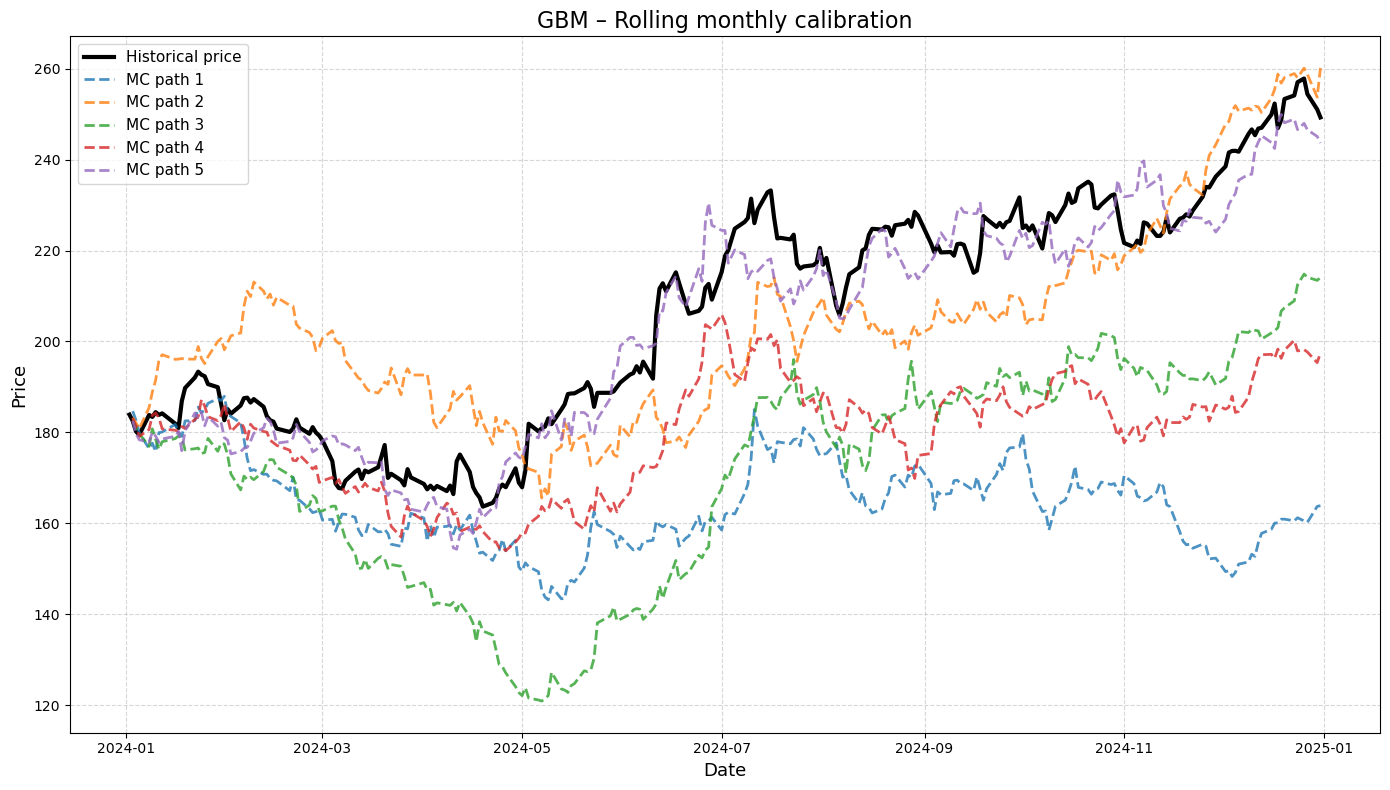

In [53]:
S_short = simulate_gbm_mc_short_window(prices,ticker1,year1-1,year1,n_paths=5)

plot_mc_vs_history(prices,S_short,"GBM – Rolling monthly calibration")


In [54]:
#Statistical tests 

def simulated_returns(S):
    return np.log(S[1:, :] / S[:-1, :]).flatten()

def run_tests(returns):
    returns = np.asarray(returns)

    #Jarque–Bera
    _, jb_p = stats.jarque_bera(returns)

    #Ljung–Box (lag 10)
    lb_p = acorr_ljungbox(returns, lags=[10], return_df=True)["lb_pvalue"].iloc[0]

    #Likelihood ratio: GBM vs RW
    mu_hat = returns.mean()
    sigma_hat = returns.std(ddof=0)
    dt = 1.0

    ll_gbm = np.sum(stats.norm.logpdf(returns,loc=(mu_hat - 0.5 * sigma_hat**2) * dt,scale=sigma_hat * np.sqrt(dt)))

    ll_rw = np.sum(stats.norm.logpdf(returns,loc=-0.5 * sigma_hat**2 * dt,scale=sigma_hat * np.sqrt(dt)))

    LR_stat = 2 * (ll_gbm - ll_rw)
    LR_p = 1 - stats.chi2.cdf(LR_stat, df=1)

    return jb_p, lb_p, LR_p

r_real = logreturns(prices).values
r_hist = simulated_returns(S_hist)
r_rand = simulated_returns(S_rand)
r_roll = simulated_returns(S_short)  

models = [
    ("Real data", r_real),
    ("GBM – Historical calibration", r_hist),
    ("GBM – Random parameters", r_rand),
    ("GBM – Rolling calibration", r_roll),]

rows = []
for name, r in models:
    jb_p, lb_p, lr_p = run_tests(r)
    rows.append([name, jb_p, lb_p, lr_p])

results = pd.DataFrame(
    rows,
    columns=[
        "Model",
        "JB p-value (normality)",
        "LB p-value (independence)",
        "LR p-value (GBM vs RW)"])

results["Normality (5%)"] = results["JB p-value (normality)"].apply(lambda p: "Reject" if p < 0.05 else "Not rejected")
results["Independence (5%)"] = results["LB p-value (independence)"].apply(lambda p: "Reject" if p < 0.05 else "Not rejected")
results["Drift significant (5%)"] = results["LR p-value (GBM vs RW)"].apply(lambda p: "Yes" if p < 0.05 else "No")

results


,Model,JB p-value (normality),LB p-value (independence),LR p-value (GBM vs RW),Normality (5%),Independence (5%),Drift significant (5%)
0,Real data,1.427674e-27,0.656423,0.140164,Reject,Not rejected,No
1,GBM – Historical calibration,9.730306e-01,0.224741,0.000253,Not rejected,Not rejected,Yes
2,GBM – Random parameters,5.205073e-01,0.702044,0.616531,Not rejected,Not rejected,No
3,GBM – Rolling calibration,1.693233e-09,0.000236,0.092906,Reject,Reject,No
